<a href="https://colab.research.google.com/github/gtbnhyujmj2003/Cat-Dog-Classification/blob/master/%5BCatDog%5D%5B02%5D%20VGG16%20-%20%5BFinaled%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 因為圖片實在太多，所以要用壓縮檔載入
import zipfile

f = zipfile.ZipFile("/content/drive/My Drive/CatDog/train.zip")
f.extractall("./datasets")

In [2]:
from glob import glob

# Cat = 0
catfs = glob("./datasets/train/cat.*.jpg")
catans = [0] * len(catfs)

# Dog = 1
dogfs = glob("datasets/train/dog.*.jpg")
dogans = [1] * len(dogfs)

In [3]:
# 製作表格
import pandas as pd

df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})

In [4]:
# 創造資料夾

import os

for class_num in range(2):
  DATASET_PATH_TRAIN = '/content/train_images/'

  # exist_ok：只有在目录不存在时创建目录，目录已存在时不会抛出异常。
  os.makedirs(DATASET_PATH_TRAIN + str(class_num), exist_ok=True)

In [5]:
Size = 224

In [6]:
# 移動檔案
import cv2
import shutil
from PIL import Image
import numpy as np

for class_num in range(2):
  class_list = df[df["target"] == class_num]["path"]

  for path in class_list:
    # 讀取檔案與轉換
    image = Image.open(path)
    image = image.resize((Size, Size))
    array = np.array(image)
    # array = np.reshape(array, newshape=(Size, Size, 3))
    array = (array-127.5)/127.5

    # 存檔
    name = path.split("/")[-1]
    foldername = class_num
    NewPaths = "/content/train_images/" + str(foldername) + "/" + str(name)
    cv2.imwrite(NewPaths, array)

In [7]:
# 看一下確定沒問題
image = Image.open("/content/train_images/0/cat.0.jpg")
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7F66853B6A58>


In [8]:
# Generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
Generator = ImageDataGenerator(rescale= 1. ,
                               validation_split= 0.05)

In [9]:
TrainFlowGenerator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "sparse", 
    subset= "training")

ValidFlowGenetator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "sparse", 
    subset= "validation")

Found 23750 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

VGG16 = VGG16(include_top=False, input_shape=(Size, Size, 3))

for layers in VGG16.layers:
    layers.trainable = True

x = VGG16.output
x = Flatten()(x)
x = Dense(1024, activation="tanh")(x)
y = Dense(6, activation="softmax")(x)

model = Model(inputs= VGG16.input, outputs= y)
# model.summary()

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer= Adam(learning_rate=0.0001),
              loss= SparseCategoricalCrossentropy(),
              metrics= ['accuracy'],)

In [ ]:
history = model.fit(TrainFlowGenerator,
                    epochs=50, verbose=2,
                    validation_data= ValidFlowGenetator,
)

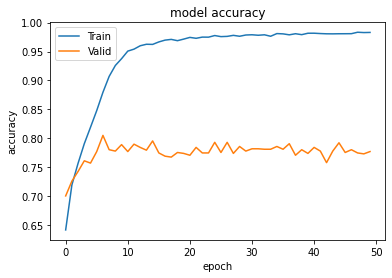

In [13]:
# accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['Train', 'Valid'], loc='upper left') 
plt.show()

In [ ]:
# 1. 秒數過長 166s or 608s
# 2. 過擬合問題嚴重
# 3. 建議換模型